# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

2025-07-01 10:35:04.055681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751358904.195001    1988 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751358904.231356    1988 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751358904.534986    1988 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751358904.535013    1988 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751358904.535015    1988 computation_placer.cc:177] computation placer alr

# Constants

In [2]:
italy_shape_path = "data/Italy/italy_rect.shx"

italy_s2_rasters = ['data/Italy/S2_italy_T32TNR_20240316.tif', 'data/Italy/S2_italy_T32TNS_20240311.tif', 'data/Italy/S2_italy_T32TPR_20240412.tif', 'data/Italy/S2_italy_T32TPS_20240412.tif']
italy_s2_merged_path = "data/Italy/S2_merged_20240311-20240412.tif"
italy_s2_path = 'data/Italy/S2_merged_20240311-20240412_repoj.tif'

italy_s1_no_process_path = "data/Italy/20240203_20240227.geo.unw.tif"
italy_s1_path = 'data/Italy/S1_inter_20240203_20240227_reproj.geo.unw.tif'

italy_capella_no_process_path = "data/Italy/Capella-Italy(20240219).tif"
italy_capella_path = "data/Italy/Capella-Italy(20240219)_reproj.tif"

ITALY_FIRST_LOCATION_RUN = False

EXPERIMENT_RUN = 'optical'  # 'optical', 'interferogram', 'all',
NUM_SIMULATIONS = 1

# Data preprocessing

#### Set up

In [3]:
italy_aoi = dp.get_aoi_geometry(italy_shape_path, ITALY_FIRST_LOCATION_RUN, 'data/Italy/italy_rect.shx')
italy_aoi = italy_aoi.set_crs("EPSG:4326", allow_override=True)
italy_aoi = italy_aoi.apply(dp.shrink_polygon)

if ITALY_FIRST_LOCATION_RUN:
    dp.get_sentinel2(italy_aoi, italy_s2_path, italy_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=italy_s2_merged_path, list_files=italy_s2_rasters
                      )
    dp.get_interferogram(italy_aoi, italy_s1_path, ((0, 0), (0, 1), (0, 1)), 
                         italy_s1_no_process_path
                         )
    dp.get_ref_data(swiss_aoi, 'data/Italy/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Italy/50N_010E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
italy_s2_data,_ = dp.get_sentinel2(aoi=italy_aoi, file_path=italy_s2_path,
                                                   padding=((0, 0), (0, 0), (0, 1)), plot=False
                                                   )

#### InSAR - Interferogram

In [5]:
italy_s1_data,_ = dp.get_interferogram(aoi=italy_aoi, file_path=italy_s1_path, 
                                                       padding=((0, 0), (0, 1), (0, 1)), plot=False
                                                       )

#### Stacking

In [6]:
if EXPERIMENT_RUN == 'optical':
    italy_combined = italy_s2_data
elif EXPERIMENT_RUN == 'interferogram':
    italy_combined = italy_s1_data
elif EXPERIMENT_RUN == 'all':
    italy_combined = np.concatenate((italy_s2_data, italy_s1_data), axis=0)

#### Reference data

In [7]:
italy_ref_data,_ = dp.get_ref_data(aoi=italy_aoi, file_path='data/Italy/ref_data_abg_woody.tif',
                                                   padding=((0, 0), (1, 0)), plot=False
                                                   )

In [8]:
del italy_s2_data, italy_s1_data, italy_shape_path, italy_s2_rasters, \
    italy_s2_merged_path, italy_s2_path, italy_s1_no_process_path, italy_s1_path, \
    italy_capella_no_process_path, italy_capella_path

#### Formatting for models

In [9]:
italy_n_bands, italy_height, italy_width = italy_combined.shape
n_pixels = italy_height * italy_width

# Reshape to make the bands last
italy_X_2d = np.transpose(italy_combined, (1, 2, 0)).reshape(n_pixels, italy_n_bands)       # (w*h, 14)
italy_y_1d = italy_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
italy_X_2d = imputer.fit_transform(italy_X_2d)

# Split into test and train 
italy_X_train, italy_X_test, italy_y_train, italy_y_test = train_test_split(
    italy_X_2d, italy_y_1d, test_size=0.3, random_state=42
)

In [10]:
del italy_combined, italy_ref_data, italy_n_bands, n_pixels, italy_y_1d

# Experiments

### MLR

In [ ]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(italy_X_train, italy_y_train, italy_X_test, italy_y_test,
                                         italy_X_2d, italy_height, italy_width, output=False)

if ITALY_FIRST_LOCATION_RUN:
    with open('data/output/italy.txt', 'a') as file:
        file.write('MLR control (%s):\n'% EXPERIMENT_RUN)
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

: 

### RF

##### Parameter experiments

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', italy_X_train, italy_y_train, italy_X_test,
                                        italy_y_test, italy_X_2d, italy_height, italy_width)

    with open('data/output/italy.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

: 

##### Input data experiments

In [11]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [30], NUM_SIMULATIONS, 'rf', italy_X_train, italy_y_train, italy_X_test,
                                        italy_y_test, italy_X_2d, italy_height, italy_width)
    
    with open('data/output/italy.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


: 

### GBT

##### Parameter experiments

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', italy_X_train, italy_y_train, italy_X_test,
                                        italy_y_test, italy_X_2d, italy_height, italy_width)

    with open('data/output/italy.txt', 'a') as file:
        file.write('GBT Parameter Experiments Output:\n')
        file.write(str(gbt_output))
        file.write('\n\n')
    
    del gbt_output

##### Input data experiments

Training Time: 599.65 seconds
RMSE: 51.4974250793457 Mg/ha
R² Score: 0.5695921182632446


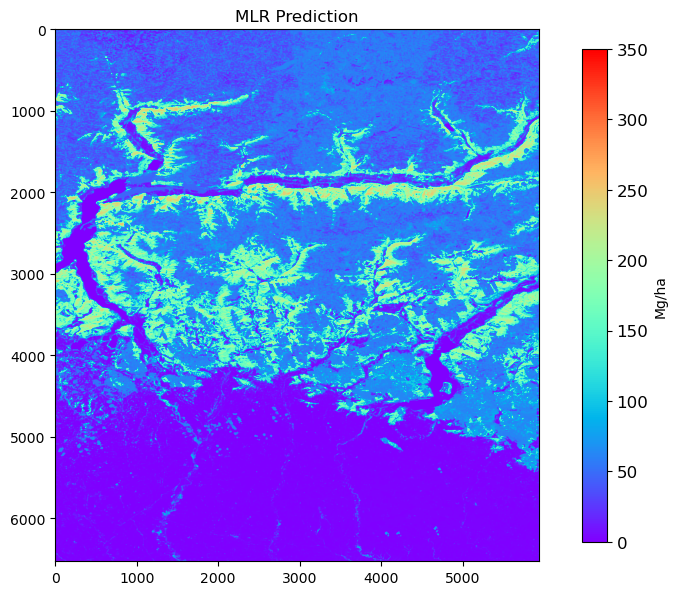

(array([61.964607 , 61.41317  , 61.964607 , ..., -3.3757455, 36.912083 ,
        61.964607 ], dtype=float32),
 599.6538722515106,
 51.497425,
 0.5695921182632446)

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_gbt = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'gbt', italy_X_train, italy_y_train, italy_X_test,
                                        italy_y_test, italy_X_2d, italy_height, italy_width)

    with open('data/output/italy.txt', 'a') as file:
        file.write('GBT Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_gbt))
        file.write('\n\n')

def cnn_model_maker(x, filters_n_kernels):
    '''Builds a model with either cyclone or river architecture for input of the 
    shape of the input x, and returns the model.'''

    input_shape = (x.shape[0], x.shape[1], x.shape[2])  # Expecting (H, W, C)
    inputs = Input(shape=input_shape)

    # First Conv + Pool
    c1 = Conv2D(filters=filters_n_kernels[0], kernel_size=filters_n_kernels[1],
                activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D(pool_size=filters_n_kernels[2], strides=2, padding='same')(c1)

    # Second Conv + Pool
    c2 = Conv2D(filters=filters_n_kernels[3], kernel_size=filters_n_kernels[4],
                activation='relu', padding='same')(p1)
    p2 = MaxPooling2D(pool_size=filters_n_kernels[5], strides=2, padding='same')(c2)

    # Upsample back to input size
    u1 = UpSampling2D(size=2)(p2)
    u2 = UpSampling2D(size=2)(u1)

    # Final convolution to single output channel
    output = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')(u2)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_logarithmic_error', 'mean_absolute_error'])

    return model

cnn_model = cnn_model_maker(de_X_tf, [8, (5,5), (2,2), 16, (5,5), (2,2), 50])
cnn_model.summary()

cnn_model.fit(de_X_tf_b, de_y_tf_b, epochs=10, batch_size=len(de_X_tf)//10)

y_pred = cnn_model.predict(de_X_test)